## DataTransformer:
A notebook to help with the transformation of `vehicle` data into the a merged format and possibly a parquet format


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/road-accidents-2019-2023/vehicles-2020.csv
/kaggle/input/road-accidents-2019-2023/char-2019.csv
/kaggle/input/road-accidents-2019-2023/char-2021.csv
/kaggle/input/road-accidents-2019-2023/place-2022.csv
/kaggle/input/road-accidents-2019-2023/users-2023.csv
/kaggle/input/road-accidents-2019-2023/users-2021.csv
/kaggle/input/road-accidents-2019-2023/vehicles-2021.csv
/kaggle/input/road-accidents-2019-2023/char-2020.csv
/kaggle/input/road-accidents-2019-2023/place-2019.csv
/kaggle/input/road-accidents-2019-2023/users-2019.csv
/kaggle/input/road-accidents-2019-2023/place-2021.csv
/kaggle/input/road-accidents-2019-2023/users-2020.csv
/kaggle/input/road-accidents-2019-2023/char-2023.csv
/kaggle/input/road-accidents-2019-2023/users-2022.csv
/kaggle/input/road-accidents-2019-2023/vehicles-2022.csv
/kaggle/input/road-accidents-2019-2023/vehicles-2019.csv
/kaggle/input/road-accidents-2019-2023/place-2020.csv
/kaggle/input/road-accidents-2019-2023/place-2023.csv
/kaggle/input/road-a

In [2]:
%%time
## all imports
import polars as pl
import pyarrow.parquet as pq
import dask.dataframe as dd
import os
import shutil
import json
from enum import Enum
from datetime import datetime
from ydata_profiling import ProfileReport
from pathlib import Path
import random

#For excel stuff
import openpyxl
from openpyxl.drawing.image import Image


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Concurrency
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
import time

#  Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random state
random_state = 42
# Set figure size
plt.rcParams["figure.figsize"] = (20, 20)


## Set the static file locactions
filepaths = {'vehicles':
    {
    2019: '/kaggle/input/road-accidents-2019-2023/vehicles-2019.csv',
    2020: '/kaggle/input/road-accidents-2019-2023/vehicles-2020.csv',
    2021: '/kaggle/input/road-accidents-2019-2023/vehicles-2021.csv',
    2022: '/kaggle/input/road-accidents-2019-2023/vehicles-2022.csv',
    2023: '/kaggle/input/road-accidents-2019-2023/vehicles-2023.csv',
    },
    'users':{
        2019: '/kaggle/input/road-accidents-2019-2023/users-2019.csv',
        2020: '/kaggle/input/road-accidents-2019-2023/users-2020.csv',
        2021: '/kaggle/input/road-accidents-2019-2023/users-2021.csv',
        2022: '/kaggle/input/road-accidents-2019-2023/users-2022.csv',
        2023: '/kaggle/input/road-accidents-2019-2023/users-2023.csv'
    },
    'places': {
        2019: '/kaggle/input/road-accidents-2019-2023/place-2019.csv',
        2020: '/kaggle/input/road-accidents-2019-2023/place-2020.csv',
        2021: '/kaggle/input/road-accidents-2019-2023/place-2021.csv',
        2022: '/kaggle/input/road-accidents-2019-2023/place-2022.csv',
        2023: '/kaggle/input/road-accidents-2019-2023/place-2023.csv'
    },
    'characteristics':{
        2019: '/kaggle/input/road-accidents-2019-2023/char-2019.csv',
        2020: '/kaggle/input/road-accidents-2019-2023/char-2020.csv',
        2021: '/kaggle/input/road-accidents-2019-2023/char-2021.csv',
        2022: '/kaggle/input/road-accidents-2019-2023/char-2022.csv',
        2023: '/kaggle/input/road-accidents-2019-2023/char-2023.csv'
    }
             
}

CPU times: user 4.76 s, sys: 844 ms, total: 5.6 s
Wall time: 7.02 s


In [3]:
class ExtensionMethods:
    @staticmethod
    def generate_filename(filename=None,extension=None):
        current_datetime = datetime.now()
        f = current_datetime.strftime("%Y_%m_%d_%H%M")
        if (filename is None) or (extension is None):
            return str(f)
        else:
            stitched_f = str(filename)+"_"+str(f)+"."+str(extension)
            return str(stitched_f)

    @staticmethod
    def get_file_name_without_extension(filename):
        if filename == None:
            return "Provide a file"
        return Path(filename).stem
        
        

In [4]:
%%time
class DataTransformer:
    def __init__(self,filedict,sep=';'): #mostly the sep is fixed with ";", just incase
        if filedict is None or not bool(filedict): ## checks if none or empty
            raise ValueError("Provide a File Path Dictionary")
        self.filedict = filedict
        self.sep = sep
        self.key = [key for key in self.filedict] ## Here key means which type of file ex. vehicle, user...
        self.years  = self.get_years()
        self.dirpath = self.create_dir()
        self._data = None
        
        

    def get_years(self):
        _years= []
        for value in self.filedict.values():
            for key, val in value.items():
                _years.append(key)
        return list(set(_years))
        
    def create_dir(self):
        merged_path = os.path.join(os.getcwd(),'Merged')
        if not os.path.exists(merged_path):
            os.makedirs(merged_path)
        return merged_path


    def _datalist_creator(self,year=None):
        '''Creates a list consisting [vehicle,user,char,place] per year where the vals are the corrs Dataframe'''
        _dataframe = []
        if year is None:
            raise ValueError("year cannot be None")
        for key, value in self.filedict.items():
            _filename = self.filedict[key][year]
            print(f"\n Reading {key} for year {year}")
            _df =  pd.read_csv(_filename,sep=self.sep)
            _dataframe.append(_df)
        return _dataframe
    
    def _merge(self,year=None):
        if year is None:
            raise ValueError("year cannot be None")
        _data = self._datalist_creator(year)
        if not _data:
            raise ValueError("_Datalist is empty")
        _merged_df = _data[0]
        for df in _data[1:]:
            _merged_df = pd.merge(_merged_df,df)
        return _merged_df

    def concat_all_merged(self):
        _mega = {}
        _dfs = []
        for year in self.years:
            print(f"\n Merging Year {year}")
            _mega[year]= self._merge(year)
        for key, value in _mega.items():
            print(f"\n Concating for {key}")
            value['csv_info'] = key
            _dfs.append(value)
        _concated = pd.concat(_dfs)
        self._data = _concated
        return _concated    
        
   
    def create_csv(self,data):
        if data is None:
            raise ValueError("Data cant be None for csv creation")
        filepath = os.path.join(self.dirpath,ExtensionMethods.generate_filename(f"merged-{'-'.join(self.key)}", "csv"))
        data.to_csv(filepath,index=False)
        print(f"\n Finished Saving csv to: {filepath}")
        
    def create_parquet(self,data):
        if data is None:
            raise ValueError("Data can't be None for Parquet Creation")
        data = self.concat_all_merged()
        obj_cols = data.select_dtypes(include =['object']).columns
        for col in obj_cols:
            data[col]=data[col].astype(str)
        filepath = os.path.join(self.dirpath,ExtensionMethods.generate_filename(f"merged-{'-'.join(self.key)}", "parquet"))
        data.to_parquet(filepath, engine='pyarrow',compression="zstd", compression_level=10, index=False)
        print(f"\n Finished Saving parquet to: {filepath}")
        
    def create_feather(self,data):
        if data is None:
            raise ValueError("Data can't be none for Feather creation")
        obj_cols = data.select_dtypes(include =['object']).columns
        for col in obj_cols:
            data[col]=data[col].astype(str)
        filepath = os.path.join(self.dirpath,ExtensionMethods.generate_filename(f"merged-{'-'.join(self.key)}", "feather"))
        data.to_parquet(filepath, compression="zstd", compression_level=10)
        print(f"\n Finished Saving feather to: {filepath}")
        

        
    def _do_magic(self):
        _data = self.concat_all_merged()
        funcs = [self.create_feather,self.create_parquet, self.create_csv]
        with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
            futures = [executor.submit(func,_data) for func in funcs]
        for future in as_completed(futures):
            print(f"Result: {future.result()}")

    
    def create_slice(self,sample_size=0.2):
        '''Get a random slice of data . Use this for local testing . It will be quite imbalanced and '''
        if self._data is None:
            self._data = self.concat_all_merged()
        data = self._data
        _rand= random.randint(1, len(data))
        print(f" Creating a Random Sample of {sample_size*100}% of data with rand: {_rand}")
        sampled_df = data.sample(frac=sample_size,random_state=_rand)
        return sampled_df
        
    def _create_slice_(self):
        '''Get a random slice of data . Use this for local testing . This kinda balances it out kinda '''
        _dfs =[]
        if self._data is None:
            self._data = self.concat_all_merged()
        data = self._data
        total_len = len(data)
        for year in self.years:
            _d = self._merge(year)
            a = len(_d)/total_len
            sample_size= (1-a)
            _rand = random.randint(1,len(_d))
            print(f"Taking a sample size of {sample_size*100}% for year {year}")
            _sampled_d = _d.sample(frac=sample_size,random_state=_rand)
            _sampled_d['csv_info']=year
            _dfs.append(_sampled_d)
        _concated = pd.concat(_dfs)
        _sample_concated= _concated.sample(frac=0.25,random_state=_rand)
        return _sample_concated
        
        

CPU times: user 42 µs, sys: 9 µs, total: 51 µs
Wall time: 56.5 µs


In [5]:
%%time
dtransformer = DataTransformer(filedict=filepaths)
a = dtransformer.create_slice(sample_size=0.1)



 Merging Year 2019

 Reading vehicles for year 2019

 Reading users for year 2019

 Reading places for year 2019

 Reading characteristics for year 2019

 Merging Year 2020

 Reading vehicles for year 2020

 Reading users for year 2020

 Reading places for year 2020

 Reading characteristics for year 2020

 Merging Year 2021

 Reading vehicles for year 2021

 Reading users for year 2021

 Reading places for year 2021

 Reading characteristics for year 2021

 Merging Year 2022

 Reading vehicles for year 2022

 Reading users for year 2022

 Reading places for year 2022

 Reading characteristics for year 2022

 Merging Year 2023

 Reading vehicles for year 2023

 Reading users for year 2023

 Reading places for year 2023

 Reading characteristics for year 2023

 Concating for 2019

 Concating for 2020

 Concating for 2021

 Concating for 2022

 Concating for 2023
 Creating a Random Sample of 10.0% of data with rand: 452199
CPU times: user 5.82 s, sys: 1.01 s, total: 6.84 s
Wall time: 8.

In [16]:
_slice = dtransformer._create_slice_()
a = dtransformer.create_csv(_slice)



 Reading vehicles for year 2019

 Reading users for year 2019

 Reading places for year 2019

 Reading characteristics for year 2019
Taking a sample size of 79.78658235352239% for year 2019

 Reading vehicles for year 2020

 Reading users for year 2020

 Reading places for year 2020

 Reading characteristics for year 2020
Taking a sample size of 83.994436548532% for year 2020

 Reading vehicles for year 2021

 Reading users for year 2021

 Reading places for year 2021

 Reading characteristics for year 2021
Taking a sample size of 80.35341597440204% for year 2021

 Reading vehicles for year 2022

 Reading users for year 2022

 Reading places for year 2022

 Reading characteristics for year 2022
Taking a sample size of 80.74650574205954% for year 2022

 Reading vehicles for year 2023

 Reading users for year 2023

 Reading places for year 2023

 Reading characteristics for year 2023
Taking a sample size of 75.11905938148405% for year 2023

 Finished Saving csv to: /kaggle/working/Merge

csv_info
2023    0.236741
2019    0.204130
2021    0.197400
2022    0.194764
2020    0.166966
Name: proportion, dtype: float64


<Axes: xlabel='csv_info'>

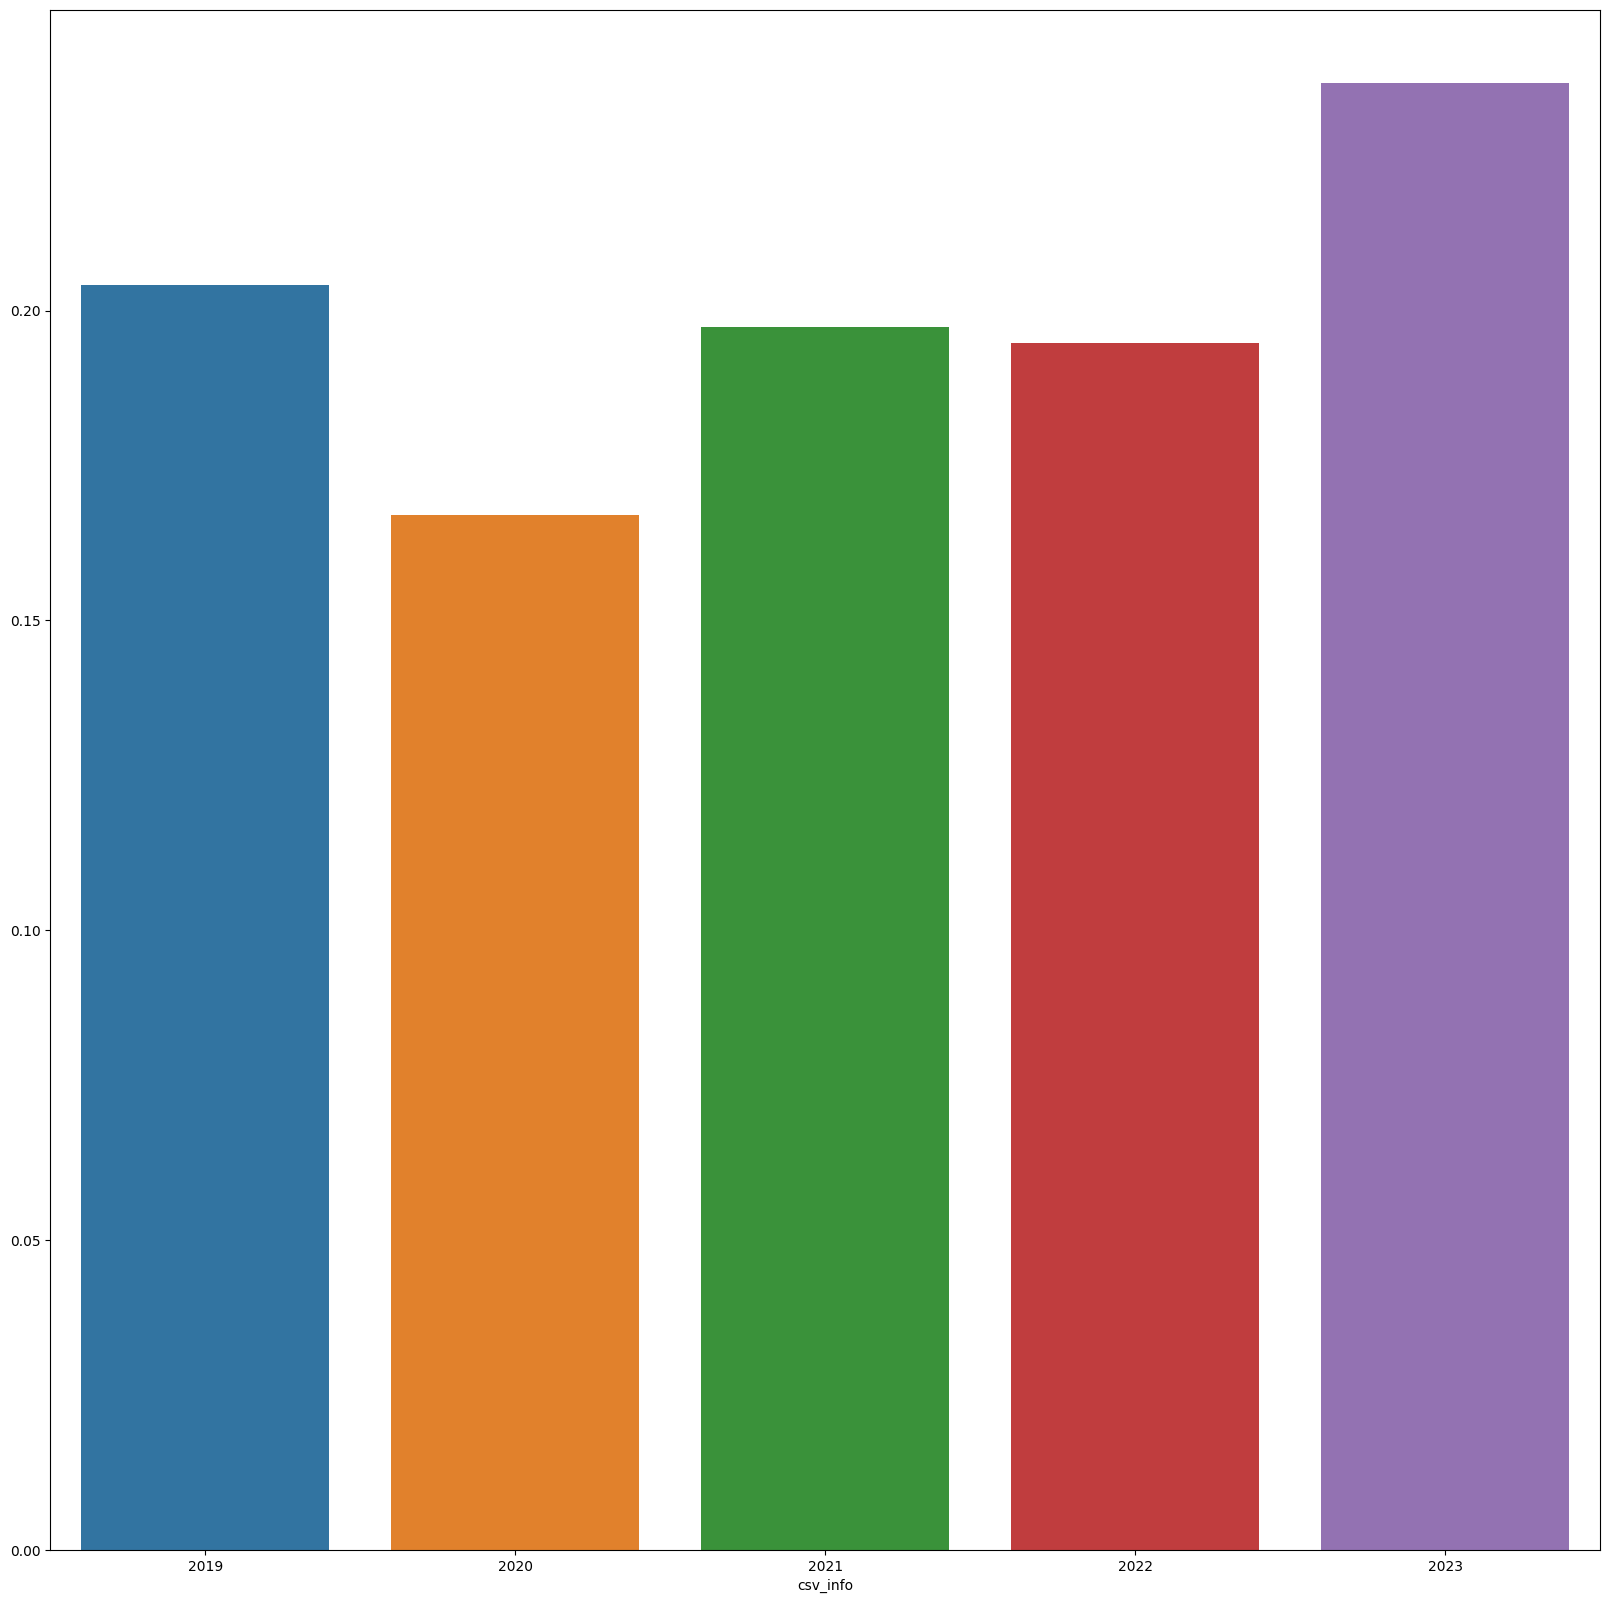

In [17]:
props = _slice['csv_info'].value_counts(normalize=True)
print(props)
sns.barplot(x=props.index,y=props.values)

In [12]:
dtransformer.create_feather(_slice)


 Finished Saving feather to: /kaggle/working/Merged/merged-vehicles-users-places-characteristics_2025_01_09_1413.feather


In [7]:
c = dtransformer.create_slice()
prop = c['csv_info'].value_counts(normalize=True)
print(prop)

 Creating a Random Sample of 20.0% of data with rand: 523759
csv_info
2023    0.250310
2019    0.202458
2021    0.197214
2022    0.191954
2020    0.158064
Name: proportion, dtype: float64


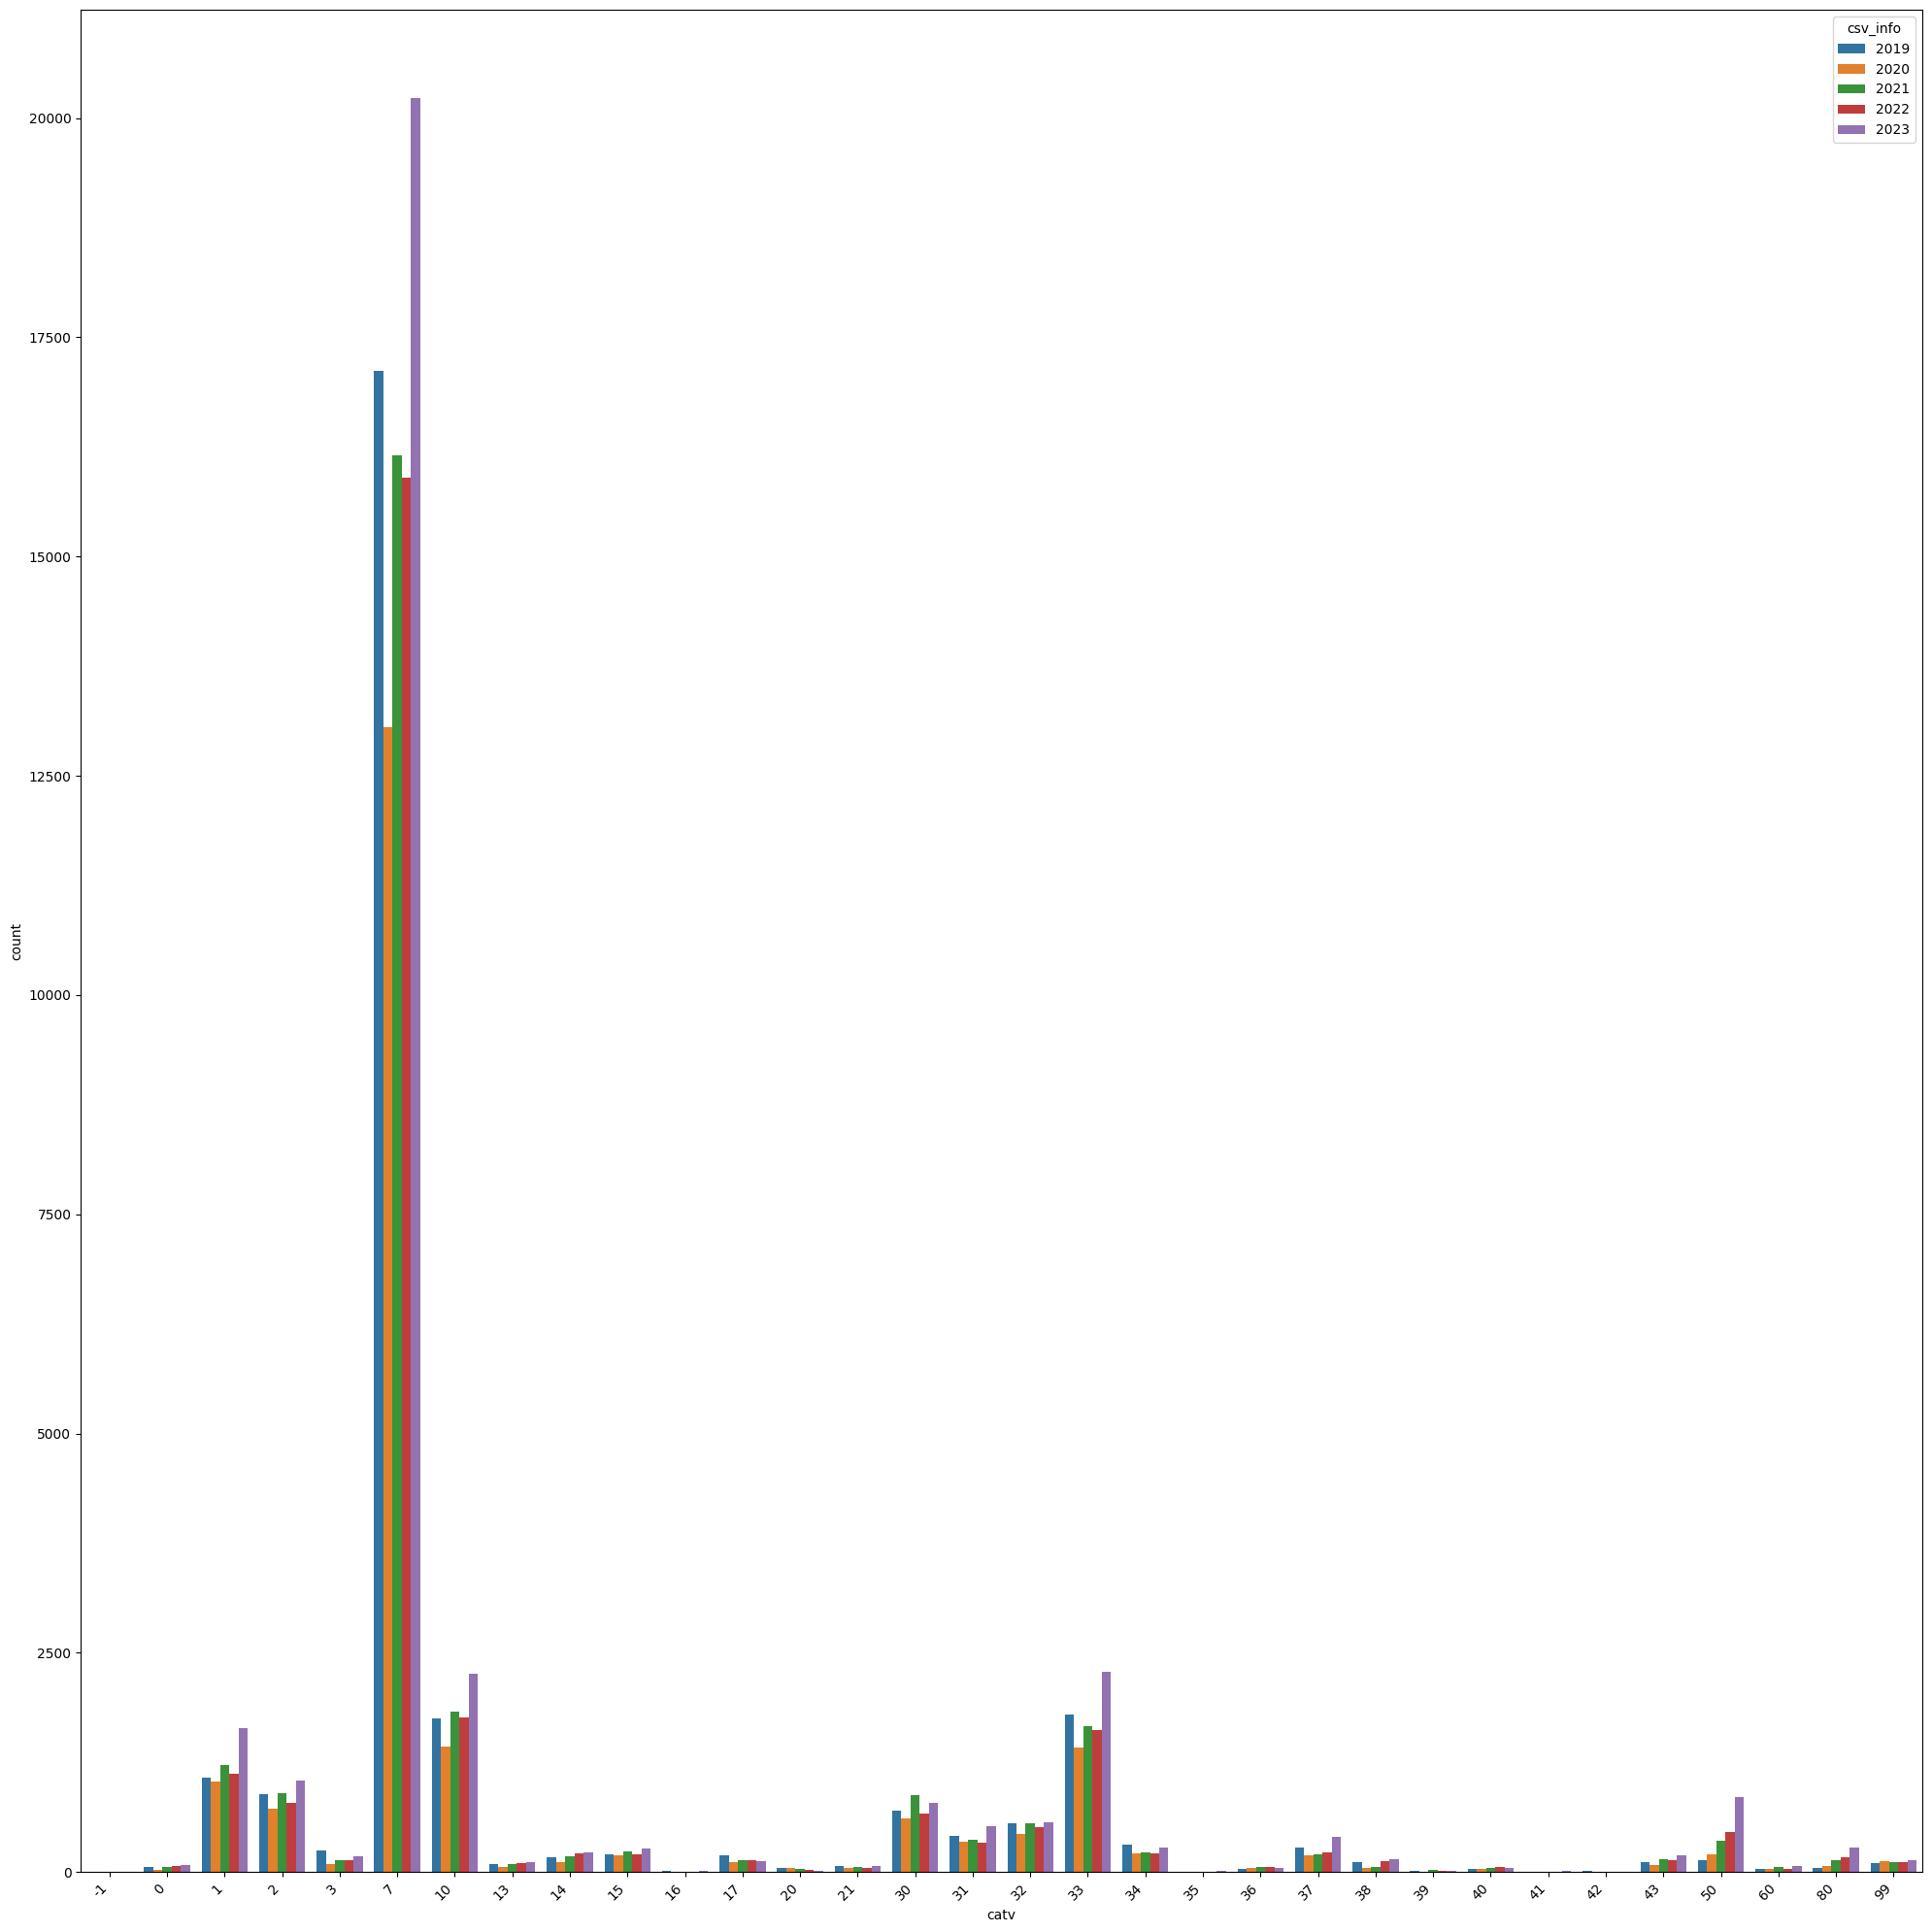

In [8]:
plt.figure()
sns.countplot(data=c,x='catv', hue='csv_info')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

In [9]:
c

,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,...,com,agg,int,atm,col,adr,lat,long,csv_info,id_usager
45137,201900019994,138 268 993,B01,3,7,0,2,4,2,1,...,91027,2,1,1,2,MITTERAND (AVENUE FRANCOIS) N° 112 A 188,"48,7127900","2,3713400",2019,NaN
44771,202100019522,166 737,A01,0,33,0,2,1,17,0,...,94001,2,1,1,1,Rue du Bac,"48,7228396256","2,4184298515",2021,221 148
11562,202200005092,804 925,B01,2,7,0,2,1,1,1,...,69173,1,1,9,3,Route du Charpenay,"45,8968728640","4,5390379429",2022,1 087 639
60116,201900026549,138 256 345,A01,1,2,0,2,1,2,1,...,63192,1,1,1,2,d129,"45,5622310","2,7058190",2019,NaN
4884,202300001652,155 677 645,B01,1,7,0,2,1,1,0,...,80443,1,3,1,5,CD 51,"49,84346900","1,91227600",2023,203 847 286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97524,202300032744,155 622 513,A01,1,10,0,2,2,15,1,...,84141,2,3,1,3,Route de Morières,"43,95643300","4,90101800",2023,203 773 550
92288,202200040296,742 140,A01,3,10,0,2,0,19,0,...,59350,2,2,1,3,DUNKERQUE AVENUE DE,"50,6303600000","3,0349600000",2022,1 003 846
40962,202100017844,169 724,B01,1,2,0,9,6,1,3,...,37261,2,2,1,3,WALVEIN (RUE),"47,3902654162","0,6706046680",2021,225 066
31511,202000014278,154 717 205,A01,2,10,0,2,1,1,3,...,75104,2,2,1,3,RUE DU PONT LOUIS PHILIPPE,"48,8546000","2,3551790",2020,NaN
